In [1]:
!nvidia-smi # Run this to see what GPU you have

Fri Mar 14 23:31:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 4.9 MB/s eta 0:00:00


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_metric_learning import samplers
import csv
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Device:  cuda


In [4]:
conf = {
    "augmented_root_dir" : "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset",
    "original_root_dir"  : "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset",
    
    "epoch" : 70, # start with 20 to test the performance at the beginning 
    'lr': 0.001,
    'checkpoint_dir': "/kaggle/working",
    'batch_size': 64,
    'num_classes': 4,
}

Verify the shape of some images

In [5]:
plt.imread("/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/00046ff7-0fae-4796-9a2b-2df47095bfe6.jpg").shape

(190, 200, 3)

In [6]:
plt.imread("/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/0033c404-4e68-438d-8312-ba5ba0100d46.jpg").shape

(180, 180, 3)

We should resize all the images to have the same shape

In [7]:
# def load_data(root, images_path_by_class, transform):
#     # iterate through the folders and load the images
#     imgs = []
#     labels = []
#     for i, img_class in tqdm(images_path_by_class, desc="Loading dataset"):
#         images_dir = os.path.join(root, img_class)
#         image_list = os.listdir(images_dir)  # Get all files in the directory
#         for img in image_list:
#             imgs.append()

# inheriet the Pytorch's Dataset class

# read the images, and lables, shuffle the array and split it into 3, and return a dictionnary with train, test and val
def read_images_and_spli(root, images_path_by_class):
    img_paths = []
    labels = []

    i = 0  # Class index
    for img_class in tqdm(images_path_by_class, desc="Loading dataset"):
        images_dir = os.path.join(root, img_class)
        image_list = os.listdir(images_dir)  # Get all files in the directory
        
        # Debug print
        print(f"Number of images in {img_class} = {len(image_list)}, Example: {image_list[-1] if image_list else 'No images'}")
        
        for img in image_list:
            img_paths.append(os.path.join(images_dir, img))
            labels.append(i)  # Assign class index as label
        i += 1
            
    assert len(img_paths) == len(labels), "Images and Labels not same size"

    # Split the dataset: 70% training, 15% validation, 15% test
    # First, split into 70% training and 30% (which we will further split)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        img_paths, labels, test_size=0.3, random_state=42, stratify=labels)
    
    # Now, split the remaining 30% into 50% for validation and 50% for test (15% each of original data)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)
    
    # Return the datasets
    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

    


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, path_array, label_array, transform):
        self.transform = transform

        self.img_paths = path_array.copy()
        self.labels = label_array.copy()
                
        assert len(self.img_paths) == len(self.labels), "Images and Labels not same size"

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):  #
        image = Image.open(self.img_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label


transformer to resize to 180, 180

In [8]:
def create_transforms(image_size: int = 244, augment = False) -> T.Compose:
    """Create transform pipeline for face recognition."""

    # Step 1: Basic transformations
    transform_list = [
        # Resize the image to the desired size (image_size x image_size)
        T.Resize((image_size, image_size)),

        # Crop to 224x224
        T.CenterCrop(image_size),

        # Convert PIL Image to tensor
        T.ToTensor(),

        # Convert image to float32 and scale the pixel values to [0, 1]
        T.ToDtype(torch.float32, scale=True),

        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]


    # Step 2: Data augmentation (optional, based on `augment` argument)
    if augment:  # This block will be executed if `augment=True`
        # TODO: Add transformations for data augmentation (e.g., random horizontal flip, rotation, etc.)
        # Example:
        transform_list.extend([
            T.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
            T.RandomRotation(degrees=(-10, 10))   # Random rotation in range (-10, 10) degrees
            # T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors slightly
            # T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Slight translation
        ])

    

    # Step 3: Standard normalization for image recognition tasks
    # The Normalize transformation requires mean and std values for each channel (R, G, B).
    # Here, we are normalizing the pixel values to have a mean of 0.5 and std of 0.5 for each channel.
    transform_list.extend([
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Standard mean and std for face recognition tasks
    ])

    # Return the composed transformation pipeline
    return T.Compose(transform_list)

gc.collect()

0

In [9]:
# augmented_root_dir = conf["augmented_root_dir"]
original_root_dir = conf["original_root_dir"]

# Transform the image to reshape it to image_size X image_size
image_size = 224
transform = create_transforms(image_size, False)
transform_train = create_transforms(image_size, True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [10]:
images_path_by_class = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
#load the datasets

(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = read_images_and_spli(
                                                                                    original_root_dir,
                                                                                    images_path_by_class
                                                                                )
# augmented_dataset = ImageDataset(augmented_root_dir, images_path_by_class, transform)
# original_dataset = ImageDataset(original_root_dir, images_path_by_class, transform)
train_dataset = ImageDataset(train_paths, train_labels, transform_train)
val_dataset = ImageDataset(val_paths, val_labels, transform)
test_dataset = ImageDataset(test_paths, test_labels, transform)


# Create DataLoaders
batch_size = 32  # You can adjust this
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Loading dataset: 100%|██████████| 4/4 [00:00<00:00, 21.49it/s]

Number of images in MildDemented = 896, Example: mildDem557.jpg
Number of images in ModerateDemented = 64, Example: moderateDem8.jpg
Number of images in NonDemented = 3200, Example: nonDem1331.jpg
Number of images in VeryMildDemented = 2240, Example: 29 (39).jpg
Train size: 4480, Val size: 960, Test size: 960


Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)


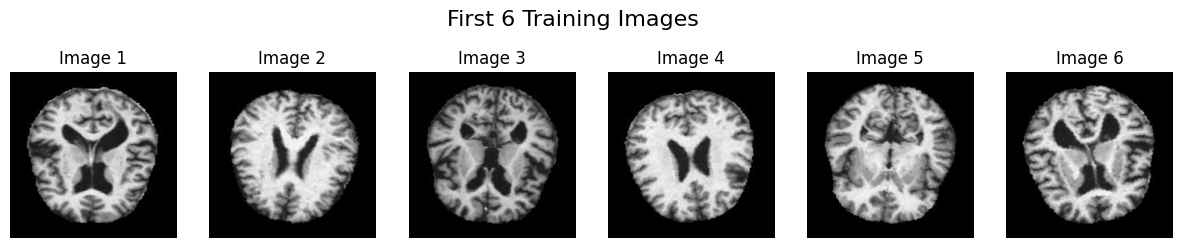

In [11]:
# # display some augmented data:
# image = augmented_dataset.__getitem__(1)[0]
# # Convert tensor (C, H, W) to NumPy (H, W, C) and move values to [0,1]
# image = image.permute(1, 2, 0).numpy() 
# print(f"Shape = {image.shape}")
# image = image * 0.5 + 0.5  # Undo normalization if applied


# plt.imshow(image)
# plt.title("What an augmented image looks like")
# plt.xticks([]); plt.yticks([]);
# plt.show()

num_images = 6
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))  # Create a 1-row grid


for i in range(num_images):
    image, label = train_dataset.__getitem__(i+6)  # Get image and label

    # Convert (C, H, W) tensor to (H, W, C) NumPy array
    image = image.permute(1, 2, 0).numpy()

    # Undo normalization if applied Normalize([0.5], [0.5]) was used)
    image = image * 0.5 + 0.5  
    print(f"Shape = {image.shape}")
    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Image {i+1}")  # Title for each image
    axes[i].axis("off")  # Hide axes

plt.suptitle("First 6 Training Images", fontsize=16)  # Set a main title
plt.show()

Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)
Shape = (224, 224, 3)


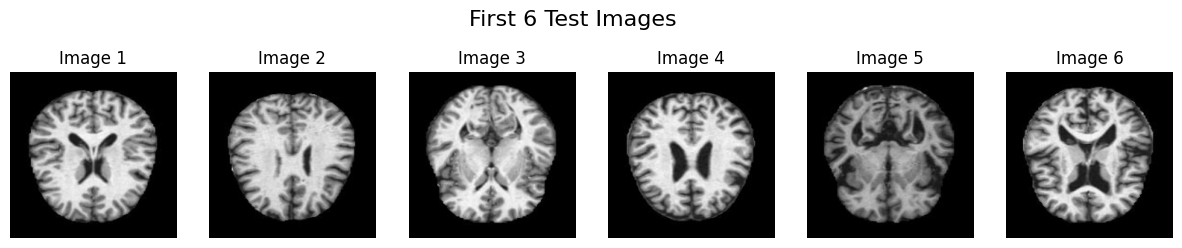

In [12]:
num_images = 6
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))  # Create a 1-row grid

for i in range(num_images):
    image, label = test_dataset.__getitem__(i)  # Get image and label

    # Convert (C, H, W) tensor to (H, W, C) NumPy array
    image = image.permute(1, 2, 0).numpy()

    # Undo normalization if applied Normalize([0.5], [0.5]) was used)
    image = image * 0.5 + 0.5  
    print(f"Shape = {image.shape}")
    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Image {i+1}")  # Title for each image
    axes[i].axis("off")  # Hide axes

plt.suptitle("First 6 Test Images", fontsize=16)  # Set a main title
plt.show()

In [13]:
class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expansion = 4  # Change expansion to 4 for ResNet-50
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(intermediate_channels)

        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(intermediate_channels)

        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(intermediate_channels * self.expansion)

        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()

        self.in_channels = 64
        self.expansion = 4  # Keep expansion factor consistent

        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.cls_layer = nn.Linear(512 * self.expansion, num_classes)

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * self.expansion:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermediate_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(intermediate_channels * self.expansion),
            )

        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        out = self.cls_layer(x)

        return {"feats": x, "out": out}


# Set up model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(Block, [3, 4, 6, 3], image_channels=3, num_classes=conf['num_classes']).to(DEVICE)

# Print model summary
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [14]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=conf['lr'], momentum=0.9, weight_decay=5e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# Mixed Precision Training
scaler = torch.amp.GradScaler('cuba')

In [15]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    output_path = "/kaggle/working/confusion_matrix.png"  
    plt.savefig(output_path)
    plt.show()

In [16]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    num_batches = len(loader)

    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        
        # Mixed precision
        with torch.amp.autocast('cuda'):
            outputs = model(images)["out"]
            loss = criterion(outputs, labels)
        
        # Backpropagation with mixed precision scaling
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Print progress for each batch
        if i % 10 == 0:  # Print every 10 batches, adjust as needed
            batch_loss = running_loss / (i+1)
            batch_acc = 100 * correct_predictions / total_samples
            print(f"Batch [{i+1}/{num_batches}], Loss: {batch_loss:.4f}, Acc: {batch_acc:.2f}%")
    
    epoch_loss = running_loss / num_batches
    epoch_acc = 100 * correct_predictions / total_samples
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()  # Switch to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    num_batches = len(loader)
    
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient tracking during validation
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            with torch.amp.autocast('cuda'):
                outputs = model(images)["out"]
                loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Store predictions and labels for precision, recall, and confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Print progress for each batch
            if i % 10 == 0:  # Print every 10 batches, adjust as needed
                batch_loss = running_loss / (i+1)
                batch_acc = 100 * correct_predictions / total_samples
                print(f"Validation Batch [{i+1}/{num_batches}], Loss: {batch_loss:.4f}, Acc: {batch_acc:.2f}%")
    
    epoch_loss = running_loss / num_batches
    epoch_acc = 100 * correct_predictions / total_samples

    # Compute precision, recall, and confusion matrix
    precision = precision_score(all_labels, all_preds, average="macro")  # Change to "micro" or "weighted" if needed
    recall = recall_score(all_labels, all_preds, average="macro")
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return epoch_loss, epoch_acc, precision, recall, conf_matrix

In [ ]:
wandb.login(key="###############################################")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gysoft-sn (gysoft-sn-carnegie-mellon-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [18]:
# Create your wandb run
run = wandb.init(
    name = "run-project-2", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "project-runs", ### Project should be created in your wandb account
    config = conf ### Wandb Config for your run
)

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250314_233218-jlyjws53
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run run-project-2
wandb: ⭐️ View project at https://wandb.ai/gysoft-sn-carnegie-mellon-university/project-runs
wandb: 🚀 View run at https://wandb.ai/gysoft-sn-carnegie-mellon-university/project-runs/runs/jlyjws53


In [19]:
best_acc = 0.0
for epoch in range(conf["epoch"]):
    print(f"\nEpoch {epoch+1}/{conf['epoch']}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
    val_loss, val_acc, val_precision, val_recall, test_conf_matrix = validate(model, val_loader, criterion, DEVICE)

    print(test_conf_matrix)

    # Log metrics to WandB
    wandb.log({
        "epoch": epoch,
        "train/loss": train_loss,
        "train/accuracy": train_acc,
        "val/loss": val_loss,
        "val/accuracy": val_acc,
        "val/precision": val_precision,
        "val/recall": val_recall
    })

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

    # Save best model based on validation accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(conf['checkpoint_dir'], "best_model.pth"))
        print("New best model saved!")



Epoch 1/70
Batch [1/140], Loss: 1.1580, Acc: 62.50%
Batch [11/140], Loss: 1.2140, Acc: 47.16%
Batch [21/140], Loss: 1.2548, Acc: 45.68%
Batch [31/140], Loss: 1.2605, Acc: 45.36%
Batch [41/140], Loss: 1.2335, Acc: 46.27%
Batch [51/140], Loss: 1.2328, Acc: 45.22%
Batch [61/140], Loss: 1.2153, Acc: 45.90%
Batch [71/140], Loss: 1.2115, Acc: 45.95%
Batch [81/140], Loss: 1.1978, Acc: 46.53%
Batch [91/140], Loss: 1.1955, Acc: 45.98%
Batch [101/140], Loss: 1.1915, Acc: 46.04%
Batch [111/140], Loss: 1.1898, Acc: 46.09%
Batch [121/140], Loss: 1.1867, Acc: 45.95%
Batch [131/140], Loss: 1.1822, Acc: 46.14%
Validation Batch [1/30], Loss: 0.8218, Acc: 75.00%
Validation Batch [11/30], Loss: 1.1700, Acc: 54.55%
Validation Batch [21/30], Loss: 1.1926, Acc: 53.27%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0   0  77  57]
 [  0   0   6   4]
 [  0   0 437  43]
 [  0   0 270  66]]
Train Loss: 1.1774, Train Acc: 46.21%
Val Loss: 1.1959, Val Acc: 52.40%
Val Precision: 0.2353, Val Recall: 0.2767
New best model saved!

Epoch 2/70
Batch [1/140], Loss: 0.9686, Acc: 65.62%
Batch [11/140], Loss: 1.1504, Acc: 47.16%
Batch [21/140], Loss: 1.1244, Acc: 48.07%
Batch [31/140], Loss: 1.1229, Acc: 49.29%
Batch [41/140], Loss: 1.1395, Acc: 48.32%
Batch [51/140], Loss: 1.1401, Acc: 48.71%
Batch [61/140], Loss: 1.1361, Acc: 48.57%
Batch [71/140], Loss: 1.1399, Acc: 48.20%
Batch [81/140], Loss: 1.1337, Acc: 48.88%
Batch [91/140], Loss: 1.1240, Acc: 49.38%
Batch [101/140], Loss: 1.1122, Acc: 50.40%
Batch [111/140], Loss: 1.1049, Acc: 50.93%
Batch [121/140], Loss: 1.1017, Acc: 51.08%
Batch [131/140], Loss: 1.1040, Acc: 51.17%
Validation Batch [1/30], Loss: 0.8764, Acc: 68.75%
Validation Batch [11/30], Loss: 1.0308, Acc: 56.53%
Validation Batch [21/30], Loss: 1.0150, Acc: 56.99%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  1   0   0 133]
 [  0   0   0  10]
 [  0   0 249 231]
 [  0   0  34 302]]
Train Loss: 1.1006, Train Acc: 51.56%
Val Loss: 1.0151, Val Acc: 57.50%
Val Precision: 0.5817, Val Recall: 0.3563
New best model saved!

Epoch 3/70
Batch [1/140], Loss: 1.0559, Acc: 50.00%
Batch [11/140], Loss: 1.0847, Acc: 46.31%
Batch [21/140], Loss: 1.0511, Acc: 51.64%
Batch [31/140], Loss: 1.0738, Acc: 51.71%
Batch [41/140], Loss: 1.1011, Acc: 51.60%
Batch [51/140], Loss: 1.0985, Acc: 51.84%
Batch [61/140], Loss: 1.0887, Acc: 52.77%
Batch [71/140], Loss: 1.0841, Acc: 52.77%
Batch [81/140], Loss: 1.0911, Acc: 51.97%
Batch [91/140], Loss: 1.0876, Acc: 51.89%
Batch [101/140], Loss: 1.0801, Acc: 52.48%
Batch [111/140], Loss: 1.0762, Acc: 52.70%
Batch [121/140], Loss: 1.0760, Acc: 52.66%
Batch [131/140], Loss: 1.0766, Acc: 52.67%
Validation Batch [1/30], Loss: 0.8911, Acc: 65.62%
Validation Batch [11/30], Loss: 1.0349, Acc: 52.84%
Validation Batch [21/30], Loss: 1.0164, Acc: 53.87%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 80   0  45   9]
 [  6   0   3   1]
 [ 63   0 409   8]
 [100   0 216  20]]
Train Loss: 1.0749, Train Acc: 52.43%
Val Loss: 1.0132, Val Acc: 53.02%
Val Precision: 0.3638, Val Recall: 0.3772

Epoch 4/70
Batch [1/140], Loss: 1.0145, Acc: 46.88%
Batch [11/140], Loss: 1.0237, Acc: 54.83%
Batch [21/140], Loss: 1.0373, Acc: 54.91%
Batch [31/140], Loss: 1.0159, Acc: 57.36%
Batch [41/140], Loss: 1.0293, Acc: 56.33%
Batch [51/140], Loss: 1.0276, Acc: 56.43%
Batch [61/140], Loss: 1.0332, Acc: 56.45%
Batch [71/140], Loss: 1.0297, Acc: 56.78%
Batch [81/140], Loss: 1.0337, Acc: 56.64%
Batch [91/140], Loss: 1.0257, Acc: 57.18%
Batch [101/140], Loss: 1.0287, Acc: 57.27%
Batch [111/140], Loss: 1.0279, Acc: 57.15%
Batch [121/140], Loss: 1.0342, Acc: 56.48%
Batch [131/140], Loss: 1.0340, Acc: 56.27%
Validation Batch [1/30], Loss: 0.8488, Acc: 65.62%
Validation Batch [11/30], Loss: 0.9971, Acc: 59.38%
Validation Batch [21/30], Loss: 0.9743, Acc: 61.16%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 67   0  17  50]
 [  6   0   0   4]
 [ 34   0 373  73]
 [ 50   0 130 156]]
Train Loss: 1.0381, Train Acc: 55.80%
Val Loss: 0.9733, Val Acc: 62.08%
Val Precision: 0.4238, Val Recall: 0.4353
New best model saved!

Epoch 5/70
Batch [1/140], Loss: 0.9238, Acc: 62.50%
Batch [11/140], Loss: 0.9552, Acc: 58.81%
Batch [21/140], Loss: 0.9542, Acc: 62.65%
Batch [31/140], Loss: 0.9858, Acc: 60.89%
Batch [41/140], Loss: 0.9843, Acc: 60.67%
Batch [51/140], Loss: 0.9974, Acc: 59.25%
Batch [61/140], Loss: 1.0003, Acc: 58.35%
Batch [71/140], Loss: 1.0088, Acc: 57.79%
Batch [81/140], Loss: 1.0056, Acc: 57.75%
Batch [91/140], Loss: 1.0047, Acc: 57.52%
Batch [101/140], Loss: 1.0025, Acc: 57.67%
Batch [111/140], Loss: 1.0006, Acc: 57.77%
Batch [121/140], Loss: 1.0125, Acc: 57.18%
Batch [131/140], Loss: 1.0148, Acc: 56.87%
Validation Batch [1/30], Loss: 0.8944, Acc: 62.50%
Validation Batch [11/30], Loss: 1.1947, Acc: 52.27%
Validation Batch [21/30], Loss: 1.1742, Acc: 52.38%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 27   0 107   0]
 [  1   0   9   0]
 [  3   0 477   0]
 [ 16   0 320   0]]
Train Loss: 1.0102, Train Acc: 57.25%
Val Loss: 1.1543, Val Acc: 52.50%
Val Precision: 0.2742, Val Recall: 0.2988

Epoch 6/70
Batch [1/140], Loss: 1.4927, Acc: 40.62%
Batch [11/140], Loss: 1.1706, Acc: 50.00%
Batch [21/140], Loss: 1.1191, Acc: 52.83%
Batch [31/140], Loss: 1.0968, Acc: 53.83%
Batch [41/140], Loss: 1.0723, Acc: 55.18%
Batch [51/140], Loss: 1.0679, Acc: 55.33%
Batch [61/140], Loss: 1.0536, Acc: 55.89%
Batch [71/140], Loss: 1.0371, Acc: 56.69%
Batch [81/140], Loss: 1.0313, Acc: 57.48%
Batch [91/140], Loss: 1.0235, Acc: 57.86%
Batch [101/140], Loss: 1.0241, Acc: 57.58%
Batch [111/140], Loss: 1.0159, Acc: 57.91%
Batch [121/140], Loss: 1.0160, Acc: 57.62%
Batch [131/140], Loss: 1.0148, Acc: 57.73%
Validation Batch [1/30], Loss: 0.7134, Acc: 78.12%
Validation Batch [11/30], Loss: 0.9719, Acc: 60.23%
Validation Batch [21/30], Loss: 0.9503, Acc: 62.20%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 18   0   9 107]
 [  1   0   0   9]
 [  2   0 396  82]
 [  4   0 140 192]]
Train Loss: 1.0093, Train Acc: 58.12%
Val Loss: 0.9387, Val Acc: 63.12%
Val Precision: 0.4847, Val Recall: 0.3827
New best model saved!

Epoch 7/70
Batch [1/140], Loss: 0.8170, Acc: 68.75%
Batch [11/140], Loss: 0.9336, Acc: 64.49%
Batch [21/140], Loss: 0.9641, Acc: 60.27%
Batch [31/140], Loss: 0.9721, Acc: 60.69%
Batch [41/140], Loss: 0.9735, Acc: 61.05%
Batch [51/140], Loss: 0.9660, Acc: 61.83%
Batch [61/140], Loss: 0.9628, Acc: 61.94%
Batch [71/140], Loss: 0.9683, Acc: 61.36%
Batch [81/140], Loss: 0.9796, Acc: 60.76%
Batch [91/140], Loss: 0.9862, Acc: 60.75%
Batch [101/140], Loss: 0.9826, Acc: 61.08%
Batch [111/140], Loss: 0.9882, Acc: 60.61%
Batch [121/140], Loss: 0.9843, Acc: 60.77%
Batch [131/140], Loss: 0.9779, Acc: 61.19%
Validation Batch [1/30], Loss: 0.7971, Acc: 71.88%
Validation Batch [11/30], Loss: 0.9283, Acc: 65.06%
Validation Batch [21/30], Loss: 0.9283, Acc: 63.24%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 31   0  10  93]
 [  2   0   2   6]
 [  7   0 323 150]
 [ 11   0  73 252]]
Train Loss: 0.9752, Train Acc: 61.47%
Val Loss: 0.9295, Val Acc: 63.12%
Val Precision: 0.4756, Val Recall: 0.4136

Epoch 8/70
Batch [1/140], Loss: 0.9902, Acc: 53.12%
Batch [11/140], Loss: 0.9109, Acc: 65.62%
Batch [21/140], Loss: 0.9589, Acc: 61.16%
Batch [31/140], Loss: 0.9509, Acc: 62.80%
Batch [41/140], Loss: 0.9550, Acc: 61.97%
Batch [51/140], Loss: 0.9462, Acc: 63.36%
Batch [61/140], Loss: 0.9465, Acc: 63.58%
Batch [71/140], Loss: 0.9456, Acc: 63.64%
Batch [81/140], Loss: 0.9488, Acc: 63.12%
Batch [91/140], Loss: 0.9520, Acc: 63.12%
Batch [101/140], Loss: 0.9487, Acc: 63.43%
Batch [111/140], Loss: 0.9554, Acc: 63.43%
Batch [121/140], Loss: 0.9616, Acc: 63.09%
Batch [131/140], Loss: 0.9623, Acc: 63.26%
Validation Batch [1/30], Loss: 1.5758, Acc: 34.38%
Validation Batch [11/30], Loss: 1.5715, Acc: 36.08%
Validation Batch [21/30], Loss: 1.5914, Acc: 35.71%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  6   0   0 128]
 [  0   0   0  10]
 [  0   0   4 476]
 [  0   0   1 335]]
Train Loss: 0.9612, Train Acc: 63.37%
Val Loss: 1.5995, Val Acc: 35.94%
Val Precision: 0.5383, Val Recall: 0.2625

Epoch 9/70
Batch [1/140], Loss: 0.9413, Acc: 68.75%
Batch [11/140], Loss: 0.9782, Acc: 62.78%
Batch [21/140], Loss: 0.9816, Acc: 63.39%
Batch [31/140], Loss: 0.9373, Acc: 65.52%
Batch [41/140], Loss: 0.9459, Acc: 64.63%
Batch [51/140], Loss: 0.9493, Acc: 64.28%
Batch [61/140], Loss: 0.9464, Acc: 64.45%
Batch [71/140], Loss: 0.9362, Acc: 64.96%
Batch [81/140], Loss: 0.9283, Acc: 65.35%
Batch [91/140], Loss: 0.9218, Acc: 65.76%
Batch [101/140], Loss: 0.9188, Acc: 65.87%
Batch [111/140], Loss: 0.9120, Acc: 66.33%
Batch [121/140], Loss: 0.9085, Acc: 66.81%
Batch [131/140], Loss: 0.9076, Acc: 66.87%
Validation Batch [1/30], Loss: 0.7310, Acc: 78.12%
Validation Batch [11/30], Loss: 0.9121, Acc: 66.48%
Validation Batch [21/30], Loss: 0.9031, Acc: 67.56%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 56   0  36  42]
 [  1   0   7   2]
 [  9   0 445  26]
 [ 27   0 165 144]]
Train Loss: 0.9089, Train Acc: 66.88%
Val Loss: 0.9090, Val Acc: 67.19%
Val Precision: 0.4891, Val Recall: 0.4434
New best model saved!

Epoch 10/70
Batch [1/140], Loss: 0.9880, Acc: 59.38%
Batch [11/140], Loss: 0.8626, Acc: 71.31%
Batch [21/140], Loss: 0.8718, Acc: 69.94%
Batch [31/140], Loss: 0.8958, Acc: 68.04%
Batch [41/140], Loss: 0.8752, Acc: 69.36%
Batch [51/140], Loss: 0.8786, Acc: 69.61%
Batch [61/140], Loss: 0.8830, Acc: 69.26%
Batch [71/140], Loss: 0.8901, Acc: 68.35%
Batch [81/140], Loss: 0.8932, Acc: 67.79%
Batch [91/140], Loss: 0.8887, Acc: 67.86%
Batch [101/140], Loss: 0.8898, Acc: 67.51%
Batch [111/140], Loss: 0.8864, Acc: 67.99%
Batch [121/140], Loss: 0.8837, Acc: 68.31%
Batch [131/140], Loss: 0.8825, Acc: 68.42%
Validation Batch [1/30], Loss: 0.7321, Acc: 75.00%
Validation Batch [11/30], Loss: 1.0049, Acc: 66.48%
Validation Batch [21/30], Loss: 1.0031, Acc: 66.67%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 42   0  47  45]
 [  1   0   5   4]
 [  5   0 449  26]
 [  7   0 182 147]]
Train Loss: 0.8808, Train Acc: 68.53%
Val Loss: 0.9967, Val Acc: 66.46%
Val Precision: 0.5208, Val Recall: 0.4216

Epoch 11/70
Batch [1/140], Loss: 0.8303, Acc: 75.00%
Batch [11/140], Loss: 0.8149, Acc: 75.00%
Batch [21/140], Loss: 0.8672, Acc: 70.83%
Batch [31/140], Loss: 0.8776, Acc: 71.37%
Batch [41/140], Loss: 0.8766, Acc: 71.42%
Batch [51/140], Loss: 0.8702, Acc: 71.38%
Batch [61/140], Loss: 0.8674, Acc: 71.62%
Batch [71/140], Loss: 0.8651, Acc: 71.74%
Batch [81/140], Loss: 0.8559, Acc: 72.18%
Batch [91/140], Loss: 0.8523, Acc: 72.12%
Batch [101/140], Loss: 0.8516, Acc: 72.18%
Batch [111/140], Loss: 0.8470, Acc: 72.30%
Batch [121/140], Loss: 0.8493, Acc: 72.08%
Batch [131/140], Loss: 0.8510, Acc: 72.09%
Validation Batch [1/30], Loss: 0.6968, Acc: 81.25%
Validation Batch [11/30], Loss: 0.8900, Acc: 72.73%
Validation Batch [21/30], Loss: 0.8773, Acc: 71.58%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 42   0  42  50]
 [  0   0   7   3]
 [  2   0 460  18]
 [  6   0 146 184]]
Train Loss: 0.8476, Train Acc: 72.21%
Val Loss: 0.8655, Val Acc: 71.46%
Val Precision: 0.5660, Val Recall: 0.4548
New best model saved!

Epoch 12/70
Batch [1/140], Loss: 0.7344, Acc: 84.38%
Batch [11/140], Loss: 0.7781, Acc: 76.42%
Batch [21/140], Loss: 0.7760, Acc: 76.49%
Batch [31/140], Loss: 0.7952, Acc: 76.01%
Batch [41/140], Loss: 0.7853, Acc: 75.69%
Batch [51/140], Loss: 0.7760, Acc: 76.10%
Batch [61/140], Loss: 0.7863, Acc: 75.41%
Batch [71/140], Loss: 0.7981, Acc: 74.56%
Batch [81/140], Loss: 0.7968, Acc: 75.00%
Batch [91/140], Loss: 0.8052, Acc: 74.48%
Batch [101/140], Loss: 0.8135, Acc: 74.07%
Batch [111/140], Loss: 0.8142, Acc: 74.32%
Batch [121/140], Loss: 0.8148, Acc: 74.17%
Batch [131/140], Loss: 0.8165, Acc: 74.17%
Validation Batch [1/30], Loss: 0.6725, Acc: 78.12%
Validation Batch [11/30], Loss: 0.8946, Acc: 69.89%
Validation Batch [21/30], Loss: 0.8977, Acc: 69.79%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 29   0  25  80]
 [  0   0   1   9]
 [  6   0 387  87]
 [  6   0  77 253]]
Train Loss: 0.8193, Train Acc: 74.06%
Val Loss: 0.9047, Val Acc: 69.69%
Val Precision: 0.5217, Val Recall: 0.4439

Epoch 13/70
Batch [1/140], Loss: 0.7492, Acc: 75.00%
Batch [11/140], Loss: 0.8482, Acc: 69.60%
Batch [21/140], Loss: 0.8488, Acc: 70.39%
Batch [31/140], Loss: 0.8285, Acc: 71.47%
Batch [41/140], Loss: 0.8277, Acc: 71.95%
Batch [51/140], Loss: 0.8169, Acc: 72.86%
Batch [61/140], Loss: 0.8064, Acc: 73.87%
Batch [71/140], Loss: 0.8049, Acc: 73.77%
Batch [81/140], Loss: 0.7991, Acc: 74.27%
Batch [91/140], Loss: 0.8009, Acc: 74.24%
Batch [101/140], Loss: 0.8029, Acc: 74.32%
Batch [111/140], Loss: 0.8053, Acc: 74.27%
Batch [121/140], Loss: 0.7997, Acc: 74.51%
Batch [131/140], Loss: 0.8036, Acc: 74.24%
Validation Batch [1/30], Loss: 1.0826, Acc: 71.88%
Validation Batch [11/30], Loss: 1.2730, Acc: 60.23%
Validation Batch [21/30], Loss: 1.2151, Acc: 61.90%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 67   0  64   3]
 [  0   0   9   1]
 [  1   0 479   0]
 [ 15   0 278  43]]
Train Loss: 0.8075, Train Acc: 74.13%
Val Loss: 1.2180, Val Acc: 61.35%
Val Precision: 0.5748, Val Recall: 0.4065

Epoch 14/70
Batch [1/140], Loss: 0.7676, Acc: 75.00%
Batch [11/140], Loss: 0.6813, Acc: 81.25%
Batch [21/140], Loss: 0.7083, Acc: 81.55%
Batch [31/140], Loss: 0.7025, Acc: 82.16%
Batch [41/140], Loss: 0.7148, Acc: 80.72%
Batch [51/140], Loss: 0.7156, Acc: 80.58%
Batch [61/140], Loss: 0.7224, Acc: 80.23%
Batch [71/140], Loss: 0.7301, Acc: 80.02%
Batch [81/140], Loss: 0.7378, Acc: 79.44%
Batch [91/140], Loss: 0.7384, Acc: 79.60%
Batch [101/140], Loss: 0.7408, Acc: 79.15%
Batch [111/140], Loss: 0.7386, Acc: 79.28%
Batch [121/140], Loss: 0.7369, Acc: 79.44%
Batch [131/140], Loss: 0.7345, Acc: 79.68%
Validation Batch [1/30], Loss: 0.6705, Acc: 84.38%
Validation Batch [11/30], Loss: 0.8317, Acc: 74.15%
Validation Batch [21/30], Loss: 0.7847, Acc: 76.34%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 76   0   6  52]
 [  2   0   0   8]
 [ 14   0 365 101]
 [ 12   0  29 295]]
Train Loss: 0.7341, Train Acc: 79.62%
Val Loss: 0.7739, Val Acc: 76.67%
Val Precision: 0.5725, Val Recall: 0.5514
New best model saved!

Epoch 15/70
Batch [1/140], Loss: 0.8696, Acc: 71.88%
Batch [11/140], Loss: 0.7138, Acc: 78.98%
Batch [21/140], Loss: 0.6976, Acc: 81.10%
Batch [31/140], Loss: 0.7048, Acc: 80.24%
Batch [41/140], Loss: 0.6935, Acc: 80.72%
Batch [51/140], Loss: 0.6940, Acc: 81.07%
Batch [61/140], Loss: 0.7070, Acc: 80.53%
Batch [71/140], Loss: 0.7048, Acc: 81.12%
Batch [81/140], Loss: 0.7034, Acc: 81.10%
Batch [91/140], Loss: 0.7002, Acc: 81.42%
Batch [101/140], Loss: 0.7105, Acc: 80.85%
Batch [111/140], Loss: 0.7132, Acc: 80.74%
Batch [121/140], Loss: 0.7096, Acc: 80.91%
Batch [131/140], Loss: 0.7092, Acc: 80.82%
Validation Batch [1/30], Loss: 0.8352, Acc: 65.62%
Validation Batch [11/30], Loss: 0.8614, Acc: 73.30%
Validation Batch [21/30], Loss: 0.8676, Acc: 74.55%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 89   0   3  42]
 [  1   0   1   8]
 [ 26   0 317 137]
 [ 20   0  11 305]]
Train Loss: 0.7138, Train Acc: 80.45%
Val Loss: 0.8578, Val Acc: 74.06%
Val Precision: 0.5573, Val Recall: 0.5581

Epoch 16/70
Batch [1/140], Loss: 0.6137, Acc: 81.25%
Batch [11/140], Loss: 0.6911, Acc: 78.98%
Batch [21/140], Loss: 0.6803, Acc: 81.55%
Batch [31/140], Loss: 0.6841, Acc: 81.65%
Batch [41/140], Loss: 0.6903, Acc: 81.94%
Batch [51/140], Loss: 0.6844, Acc: 82.11%
Batch [61/140], Loss: 0.6829, Acc: 82.22%
Batch [71/140], Loss: 0.6771, Acc: 82.57%
Batch [81/140], Loss: 0.6768, Acc: 82.37%
Batch [91/140], Loss: 0.6786, Acc: 82.14%
Batch [101/140], Loss: 0.6801, Acc: 82.21%
Batch [111/140], Loss: 0.6804, Acc: 82.24%
Batch [121/140], Loss: 0.6831, Acc: 82.33%
Batch [131/140], Loss: 0.6773, Acc: 82.80%
Validation Batch [1/30], Loss: 0.5875, Acc: 87.50%
Validation Batch [11/30], Loss: 0.7744, Acc: 76.70%
Validation Batch [21/30], Loss: 0.7603, Acc: 79.17%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[110   0  14  10]
 [  2   0   6   2]
 [ 21   0 401  58]
 [ 32   0  44 260]]
Train Loss: 0.6791, Train Acc: 82.88%
Val Loss: 0.7403, Val Acc: 80.31%
Val Precision: 0.5792, Val Recall: 0.6075
New best model saved!

Epoch 17/70
Batch [1/140], Loss: 0.6016, Acc: 87.50%
Batch [11/140], Loss: 0.6274, Acc: 84.38%
Batch [21/140], Loss: 0.6271, Acc: 85.42%
Batch [31/140], Loss: 0.6139, Acc: 86.29%
Batch [41/140], Loss: 0.6252, Acc: 86.13%
Batch [51/140], Loss: 0.6264, Acc: 86.15%
Batch [61/140], Loss: 0.6256, Acc: 86.07%
Batch [71/140], Loss: 0.6261, Acc: 86.18%
Batch [81/140], Loss: 0.6321, Acc: 85.73%
Batch [91/140], Loss: 0.6373, Acc: 85.54%
Batch [101/140], Loss: 0.6399, Acc: 85.52%
Batch [111/140], Loss: 0.6432, Acc: 85.19%
Batch [121/140], Loss: 0.6450, Acc: 85.05%
Batch [131/140], Loss: 0.6493, Acc: 84.76%
Validation Batch [1/30], Loss: 0.7695, Acc: 78.12%
Validation Batch [11/30], Loss: 0.7887, Acc: 78.69%
Validation Batch [21/30], Loss: 0.7865, Acc: 78.27%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 91   0   5  38]
 [  1   0   3   6]
 [  7   0 340 133]
 [  6   0  12 318]]
Train Loss: 0.6506, Train Acc: 84.78%
Val Loss: 0.7758, Val Acc: 78.02%
Val Precision: 0.6134, Val Recall: 0.5835

Epoch 18/70
Batch [1/140], Loss: 0.5835, Acc: 87.50%
Batch [11/140], Loss: 0.6078, Acc: 86.36%
Batch [21/140], Loss: 0.5895, Acc: 87.50%
Batch [31/140], Loss: 0.5910, Acc: 87.70%
Batch [41/140], Loss: 0.5917, Acc: 87.58%
Batch [51/140], Loss: 0.5970, Acc: 87.19%
Batch [61/140], Loss: 0.5934, Acc: 88.01%
Batch [71/140], Loss: 0.5929, Acc: 88.03%
Batch [81/140], Loss: 0.5997, Acc: 87.73%
Batch [91/140], Loss: 0.6019, Acc: 87.47%
Batch [101/140], Loss: 0.6090, Acc: 87.19%
Batch [111/140], Loss: 0.6085, Acc: 87.25%
Batch [121/140], Loss: 0.6151, Acc: 86.91%
Batch [131/140], Loss: 0.6147, Acc: 87.02%
Validation Batch [1/30], Loss: 0.6921, Acc: 84.38%
Validation Batch [11/30], Loss: 0.8390, Acc: 78.41%
Validation Batch [21/30], Loss: 0.8169, Acc: 79.32%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 97   0  22  15]
 [  4   0   4   2]
 [  1   0 475   4]
 [  5   0 141 190]]
Train Loss: 0.6125, Train Acc: 87.17%
Val Loss: 0.8105, Val Acc: 79.38%
Val Precision: 0.6367, Val Recall: 0.5697

Epoch 19/70
Batch [1/140], Loss: 0.6017, Acc: 87.50%
Batch [11/140], Loss: 0.6013, Acc: 88.64%
Batch [21/140], Loss: 0.6003, Acc: 88.69%
Batch [31/140], Loss: 0.5863, Acc: 89.31%
Batch [41/140], Loss: 0.5847, Acc: 89.25%
Batch [51/140], Loss: 0.5843, Acc: 88.97%
Batch [61/140], Loss: 0.5741, Acc: 89.40%
Batch [71/140], Loss: 0.5735, Acc: 89.30%
Batch [81/140], Loss: 0.5743, Acc: 89.16%
Batch [91/140], Loss: 0.5805, Acc: 88.87%
Batch [101/140], Loss: 0.5882, Acc: 88.46%
Batch [111/140], Loss: 0.5901, Acc: 88.29%
Batch [121/140], Loss: 0.5882, Acc: 88.48%
Batch [131/140], Loss: 0.5897, Acc: 88.29%
Validation Batch [1/30], Loss: 0.6200, Acc: 84.38%
Validation Batch [11/30], Loss: 0.7123, Acc: 78.69%
Validation Batch [21/30], Loss: 0.6866, Acc: 81.10%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[132   0   2   0]
 [  5   0   3   2]
 [ 36   0 436   8]
 [ 70   0  51 215]]
Train Loss: 0.5918, Train Acc: 88.12%
Val Loss: 0.6860, Val Acc: 81.56%
Val Precision: 0.5962, Val Recall: 0.6333
New best model saved!

Epoch 20/70
Batch [1/140], Loss: 0.4948, Acc: 96.88%
Batch [11/140], Loss: 0.5249, Acc: 90.91%
Batch [21/140], Loss: 0.5274, Acc: 91.22%
Batch [31/140], Loss: 0.5309, Acc: 91.53%
Batch [41/140], Loss: 0.5412, Acc: 91.16%
Batch [51/140], Loss: 0.5332, Acc: 91.85%
Batch [61/140], Loss: 0.5373, Acc: 91.34%
Batch [71/140], Loss: 0.5400, Acc: 91.33%
Batch [81/140], Loss: 0.5393, Acc: 91.20%
Batch [91/140], Loss: 0.5375, Acc: 91.45%
Batch [101/140], Loss: 0.5420, Acc: 91.27%
Batch [111/140], Loss: 0.5439, Acc: 91.19%
Batch [121/140], Loss: 0.5407, Acc: 91.37%
Batch [131/140], Loss: 0.5402, Acc: 91.36%
Validation Batch [1/30], Loss: 0.4884, Acc: 93.75%
Validation Batch [11/30], Loss: 0.5780, Acc: 89.49%
Validation Batch [21/30], Loss: 0.5676, Acc: 88.84%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[108   0   3  23]
 [  1   0   5   4]
 [  2   0 436  42]
 [  2   0  25 309]]
Train Loss: 0.5405, Train Acc: 91.23%
Val Loss: 0.5725, Val Acc: 88.85%
Val Precision: 0.6757, Val Recall: 0.6585
New best model saved!

Epoch 21/70
Batch [1/140], Loss: 0.5559, Acc: 90.62%
Batch [11/140], Loss: 0.5197, Acc: 92.61%
Batch [21/140], Loss: 0.4980, Acc: 93.90%
Batch [31/140], Loss: 0.5078, Acc: 93.25%
Batch [41/140], Loss: 0.5016, Acc: 93.67%
Batch [51/140], Loss: 0.5020, Acc: 93.87%
Batch [61/140], Loss: 0.5005, Acc: 93.80%
Batch [71/140], Loss: 0.5024, Acc: 93.71%
Batch [81/140], Loss: 0.5054, Acc: 93.33%
Batch [91/140], Loss: 0.5086, Acc: 93.17%
Batch [101/140], Loss: 0.5100, Acc: 93.19%
Batch [111/140], Loss: 0.5096, Acc: 93.16%
Batch [121/140], Loss: 0.5126, Acc: 93.08%
Batch [131/140], Loss: 0.5134, Acc: 93.13%
Validation Batch [1/30], Loss: 0.5811, Acc: 81.25%
Validation Batch [11/30], Loss: 0.6599, Acc: 84.66%
Validation Batch [21/30], Loss: 0.6206, Acc: 86.16%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[120   0   6   8]
 [  5   0   2   3]
 [  5   0 416  59]
 [ 14   0  28 294]]
Train Loss: 0.5133, Train Acc: 93.12%
Val Loss: 0.6190, Val Acc: 86.46%
Val Precision: 0.6403, Val Recall: 0.6593

Epoch 22/70
Batch [1/140], Loss: 0.4623, Acc: 100.00%
Batch [11/140], Loss: 0.4934, Acc: 93.47%
Batch [21/140], Loss: 0.5017, Acc: 93.60%
Batch [31/140], Loss: 0.5014, Acc: 93.25%
Batch [41/140], Loss: 0.4969, Acc: 94.05%
Batch [51/140], Loss: 0.4913, Acc: 94.55%
Batch [61/140], Loss: 0.4936, Acc: 94.47%
Batch [71/140], Loss: 0.4907, Acc: 94.59%
Batch [81/140], Loss: 0.4985, Acc: 94.06%
Batch [91/140], Loss: 0.5025, Acc: 93.72%
Batch [101/140], Loss: 0.5045, Acc: 93.56%
Batch [111/140], Loss: 0.5056, Acc: 93.44%
Batch [121/140], Loss: 0.5055, Acc: 93.52%
Batch [131/140], Loss: 0.5065, Acc: 93.46%
Validation Batch [1/30], Loss: 0.4703, Acc: 96.88%
Validation Batch [11/30], Loss: 0.6208, Acc: 86.08%
Validation Batch [21/30], Loss: 0.5831, Acc: 88.69%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[110   0   4  20]
 [  1   0   5   4]
 [  0   0 444  36]
 [  0   0  31 305]]
Train Loss: 0.5054, Train Acc: 93.44%
Val Loss: 0.5753, Val Acc: 89.48%
Val Precision: 0.6860, Val Recall: 0.6634
New best model saved!

Epoch 23/70
Batch [1/140], Loss: 0.5646, Acc: 87.50%
Batch [11/140], Loss: 0.4811, Acc: 94.60%
Batch [21/140], Loss: 0.4858, Acc: 94.64%
Batch [31/140], Loss: 0.4876, Acc: 94.05%
Batch [41/140], Loss: 0.4813, Acc: 94.51%
Batch [51/140], Loss: 0.4789, Acc: 94.73%
Batch [61/140], Loss: 0.4811, Acc: 94.42%
Batch [71/140], Loss: 0.4795, Acc: 94.63%
Batch [81/140], Loss: 0.4808, Acc: 94.68%
Batch [91/140], Loss: 0.4793, Acc: 94.64%
Batch [101/140], Loss: 0.4814, Acc: 94.49%
Batch [111/140], Loss: 0.4847, Acc: 94.31%
Batch [121/140], Loss: 0.4842, Acc: 94.34%
Batch [131/140], Loss: 0.4852, Acc: 94.25%
Validation Batch [1/30], Loss: 0.4935, Acc: 96.88%
Validation Batch [11/30], Loss: 0.5790, Acc: 88.07%
Validation Batch [21/30], Loss: 0.5650, Acc: 88.99%
[[116   0   4  14]
 [  3   1

In [20]:
# model.load_state_dict(torch.load("/kaggle/input/best-model-from-run-5/pytorch/default/1/best_model_ALZHEIMER.pth"))
# model.eval()


Evaluating on the test dataset...
Validation Batch [1/30], Loss: 0.4872, Acc: 93.75%
Validation Batch [11/30], Loss: 0.4498, Acc: 96.02%
Validation Batch [21/30], Loss: 0.4372, Acc: 96.13%

Test Loss: 0.4365, Test Acc: 95.73%
Test Precision: 0.9737, Test Recall: 0.9296
[[121   0   2  12]
 [  0   8   0   1]
 [  0   0 468  12]
 [  0   0  14 322]]


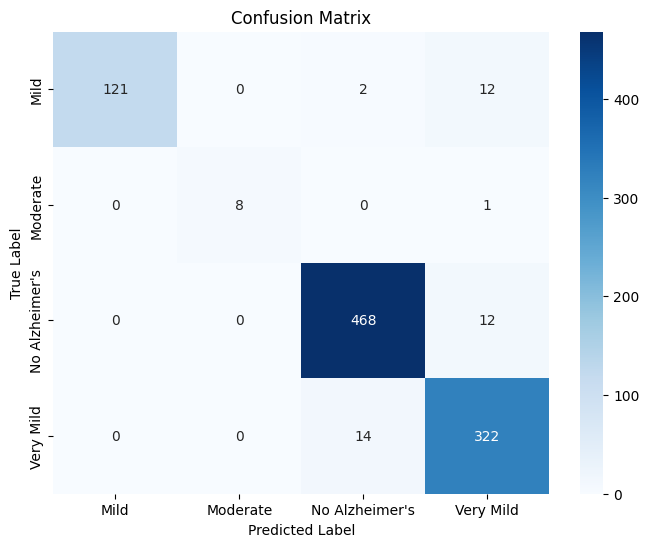


Confusion Matrix:
[[121   0   2  12]
 [  0   8   0   1]
 [  0   0 468  12]
 [  0   0  14 322]]


In [21]:
# After training, evaluate on the test dataset
print("\nEvaluating on the test dataset...")
test_loss, test_acc, test_precision, test_recall, test_conf_matrix = validate(model, test_loader, criterion, DEVICE)

print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

print(test_conf_matrix)

class_names = ["Mild", "Moderate", "No Alzheimer's", "Very Mild"]
plot_confusion_matrix(test_conf_matrix, class_names)


print("\nConfusion Matrix:")
print(test_conf_matrix)


In [22]:
from PIL import Image
import torch
from torchvision import transforms

def predict_image(model, image_path, transform, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the same transformations as during training
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model (CPU or GPU)
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():  # No need to compute gradients for inference
        outputs = model(image)['out']  # Assuming 'out' is the output of the model
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

    return predicted.item()  # Return the predicted class index

# Define your transform (the same as the training transform without augmentation)
transform_predict = create_transforms(image_size=224, augment=False)

# Provide the path of the image you want to predict
image_path = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset/ModerateDemented/28.jpg"

# Call the prediction function
predicted_class = predict_image(model, image_path, transform_predict, DEVICE)

# Print the predicted class index
print(f"Predicted class: {predicted_class}")


Predicted class: 1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [23]:
import requests
from io import BytesIO
from PIL import Image
import torch
from torchvision import transforms

def predict_image_from_url(model, image_url, transform, device):
    # Download the image from the URL
    response = requests.get(image_url)
    response.raise_for_status()  # Raise an error for bad responses (404, 500, etc.)

    # Open the image
    image = Image.open(BytesIO(response.content)).convert('RGB')

    # Apply transformations
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model (CPU or GPU)
    image = image.to(device)

    # Set model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        outputs = model(image)['out']  # Assuming 'out' is the output of the model
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

    return predicted.item()  # Return the predicted class index

# Define your transform (the same as the training transform without augmentation)
transform_predict = create_transforms(image_size=224, augment=False)

# Provide the URL of the image you want to predict
image_url = "https://3acf3052-cdn.agilitycms.cloud/images/service/Brain%20AI%20enhanced.jpg"

# Call the prediction function
predicted_class = predict_image_from_url(model, image_url, transform_predict, DEVICE)

# Print the predicted class index
print(f"Predicted class: {predicted_class}")


Predicted class: 2
